In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sys import stdout
import time
import jax
import jax.numpy as jnp
import numpy as np
import openmm.app as app
import openmm.unit as unit
import openmm as mm
#import dmff
from dmff import Hamiltonian, NeighborListFreud, NeighborList
#from jax import config
import nglview as nv
#from tqdm import tqdm
import mdtraj
import pandas
from scipy.stats import gaussian_kde
from openmm import app, unit, LangevinMiddleIntegrator, System, CustomExternalForce
from openmm.app import Simulation, PDBFile, DCDReporter, StateDataReporter
import time

/Users/arminsh/miniconda3/envs/GAD/lib/python3.9/site-packages/dmff/admp/qeq.py:33: UserWarning: jaxopt not found, QEQ cannot be used.
  warnings.warn("jaxopt not found, QEQ cannot be used.")


In [2]:
path = os.path.abspath("")
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")
ff = Hamiltonian(f"{path}/protein.ff14SB.xml")

## Testing to see if DMFF is comparable to OpenMM

### DMFF testing

In [3]:
potentials = ff.createPotential(prmtop.topology, nonbondedMethod=app.NoCutoff, useDispersionCorrection=False)
params = ff.getParameters()
positions = jnp.array(inpcrd.getPositions(asNumpy=True).value_in_unit(unit.nanometer))
box = jnp.array([[20.0, 0.0, 0.0], [0.0, 20.0, 0.0], [0.0, 0.0, 20.0]])
nbList = NeighborListFreud(box, 3, potentials.meta["cov_map"]) # maybe remove the box?
nbList.allocate(positions)
pairs = nbList.pairs
efunc_all = potentials.getPotentialFunc()
dmff_e = efunc_all(positions, box, pairs, ff.paramset)
print("DMFF Pot E: ", dmff_e)


DMFF Pot E:  -55.794260834909345


### OpenMM testing

In [4]:
# openmm testing
forcefield = app.ForceField(f"{path}/protein.ff14SB.xml")
system = forcefield.createSystem(prmtop.topology, nonbondedMethod=app.NoCutoff)
integrator = mm.VerletIntegrator(0.001*unit.picoseconds)
platform = mm.Platform.getPlatformByName('Reference') # check what this is - why is it there? 
simulation = app.Simulation(prmtop.topology, system, integrator, platform) 
simulation.context.setPositions(inpcrd.positions)

state = simulation.context.getState(getEnergy=True, getVelocities=True, getForces=True, getPositions=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E: ", energy)

OpenMM Pot E:  -55.794262524057814 kJ/mol


In [6]:
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)
# integrator = mm.VerletIntegrator(0.001*unit.picoseconds)
integrator = mm.LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
# platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(prmtop.topology, system, integrator)#, platform)
simulation.context.setPositions(inpcrd.positions)
simulation.minimizeEnergy()

state = simulation.context.getState(getEnergy=True, getVelocities=True, getForces=True, getPositions=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E: ", energy)

OpenMM Pot E:  -86.74876403808594 kJ/mol


In [7]:
simulation.reporters = []
simulation.reporters.append(app.dcdreporter.DCDReporter(f"{path}/traj_openmm_2ns.dcd", 100))
simulation.reporters.append(
    app.statedatareporter.StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    app.statedatareporter.StateDataReporter(
        "scalars1_2ns.csv",
        100,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
start = time.time()
simulation.step(1e6);
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt(f'{path}/time_openmm_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,229.07157280127956,7.414817810058594e-05
2000,300.71154954500906,0.12421011924743652
3000,237.2530139330181,0.231154203414917
4000,271.8625021673517,0.3326382637023926
5000,256.74854576268064,0.4319570064544678
6000,424.8845691185041,0.5309441089630127
7000,334.02122724462913,0.6315021514892578
8000,358.5683059857498,0.7326712608337402
9000,258.1061262105033,0.8336522579193115
10000,270.060743323831,0.9320602416992188
11000,249.17081304944634,1.0294702053070068
12000,339.4328701184327,1.1269922256469727
13000,270.6745118754211,1.2254502773284912
14000,294.0905758724237,1.32399320602417
15000,291.72330150410124,1.42258620262146
16000,257.8551057225167,1.5227251052856445
17000,255.76868689196013,1.6248791217803955
18000,299.03778210270156,1.7436490058898926
19000,308.98872887901194,1.8724310398101807
20000,479.47753824813225,1.9910383224487305
21000,251.00844666673322,2.089221239089966
22000,299.83300883153476,2.1908931732177734
23000,334

102.77448606491089


<Axes: xlabel='#"Time (ps)"'>

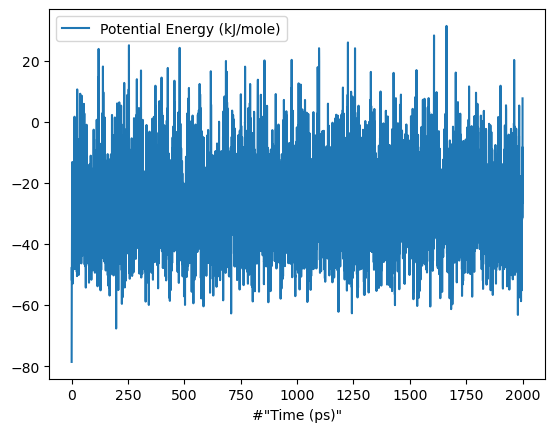

In [8]:
print(end-start)
df1 = pandas.read_csv(f"{path}/scalars1_2ns.csv")
plt.close("ener1")
fig, ax = plt.subplots(num="ener1")
df1.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)", ax=ax)

In [7]:
traj1 = mdtraj.load("traj_openmm_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
traj1.superpose(traj1, 0)
nv.show_mdtraj(traj1)

NGLWidget(max_frame=9999)

In [8]:
# Ramachandran plot of md
def plot_ramachandran_contour(traj, num, phi_atoms=None, psi_atoms=None, bins=100):
    """Generate a Ramachandran plot with a contour heatmap.

    Parameters
    ----------
    traj : mdtraj.Trajectory
        An MDTraj trajectory object.
    num : str
        Figure name or identifier.
    phi_atoms : list, optional
        List of atom names to define the phi angle.
    psi_atoms : list, optional
        List of atom names to define the psi angle.
    bins : int, optional
        Number of bins for contour density estimation (default: 100).
    """

    # Compute phi and psi angles
    if phi_atoms is None:
        phis = mdtraj.compute_phi(traj)[1].ravel()
    else:
        phis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, phi_atoms)[1]
        )

    if psi_atoms is None:
        psis = mdtraj.compute_psi(traj)[1].ravel()
    else:
        psis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, psi_atoms)[1]
        )

    # Convert to degrees
    phis = phis * 180 / np.pi
    psis = psis * 180 / np.pi

    # Compute kernel density estimate (KDE)
    values = np.vstack([phis, psis])
    kde = gaussian_kde(values)(values)

    # Create contour plot
    plt.close(num)
    fig, ax = plt.subplots(figsize=(7, 5))
    sc = ax.scatter(phis, psis, c=kde, cmap="viridis", s=5)
    ax.axvline(0, color="k", linestyle="--", lw=1)
    ax.axhline(0, color="k", linestyle="--", lw=1)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xticks(np.linspace(-180, 180, 5))
    ax.set_yticks(np.linspace(-180, 180, 5))
    ax.set_xlabel("Phi (°)")
    ax.set_ylabel("Psi (°)")
    # ax.set_title("Ramachandran Plot (Contour Density)")
    fig.colorbar(sc, label="Density")

    plt.show()
    return phis, psis

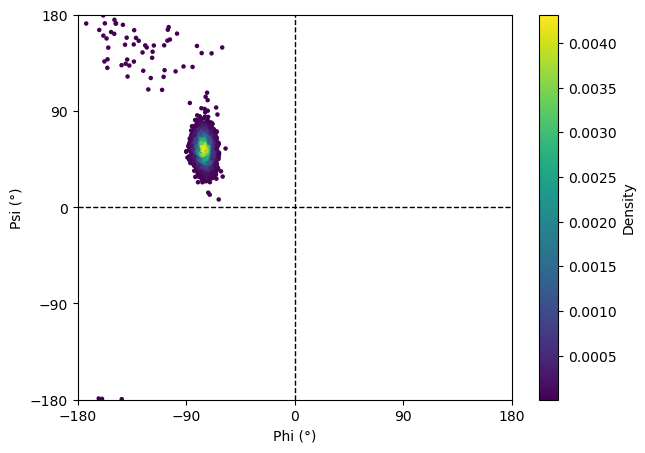

In [9]:
data = plot_ramachandran_contour(traj1, "ram1")


## Computing grad

In [10]:
params = ff.paramset # easy for implemenentation - must not change
efunc_pos = lambda pos: efunc_all(pos.reshape(-1, 3), box, pairs, ff.paramset) # for easy implementation 

grad_vec = jax.grad(efunc_pos)
force = grad_vec(positions.flatten())
print("Forces: \n", force)
force.shape

Forces: 
 [-1.71865366e+02 -3.18532912e+01  6.93394280e-01 -2.69338193e+02
 -3.51439108e+02 -2.29458474e+00 -5.28602801e+00  4.40961711e+01
  4.26381335e+01 -6.79627810e+00  4.33137449e+01 -4.09523736e+01
  4.52549770e+02  2.17764116e+02 -2.35854039e+02  6.63423153e+02
  4.01344132e+02 -3.88141697e+02  9.49967236e+01  7.69630908e+02
  4.01534867e+02 -4.90775901e+01 -4.57633388e+01  7.38115682e+00
 -4.28528076e+02 -3.13662037e+02 -1.89956133e+02  1.74440184e+01
  8.66267050e+00 -4.23307622e+01  1.04952670e+01  1.14678495e+02
  3.50646113e+02 -1.77497554e+01  2.76645948e+01  6.28447219e+01
 -8.25922834e+01  2.01080786e+02  1.30534383e+02 -4.08666513e+02
 -2.61975927e+02  3.33848622e+02  5.80858470e+01 -1.93137316e+01
 -2.68883324e+02  2.16593345e+02  4.39660829e+01  1.80234687e+01
  6.44641858e+01 -3.42606470e+02 -1.88895749e+02  1.40152566e+02
  1.03662316e+02  6.88386192e+00 -2.76119653e+02 -2.02536969e+02
  1.60757282e-01 -3.92006329e+01 -2.84702293e+02  9.29432738e-01
  1.83045552e+0

(66,)

## Computing hessians

In [11]:
def hessian_vec(positions):
  return jax.hessian(efunc_pos)(positions)

hess = hessian_vec(positions.flatten())
print(hess.shape)

# Compute the eigenvalues
w, v = jnp.linalg.eigh(hess)
w_idx = w.argsort()
w = w[w_idx]
v = v[:, w_idx]
v[:,0]

(66, 66)


Array([ 0.10992325, -0.04464015,  0.16530062,  0.07341035, -0.04509722,
        0.15737338,  0.04347036, -0.05198696,  0.14250302,  0.07624383,
       -0.07158852,  0.144005  ,  0.05415182,  0.00742744,  0.17615551,
        0.09462868,  0.05392625,  0.22839454,  0.00313912,  0.01105859,
        0.11434906, -0.00787663, -0.0050405 ,  0.098282  , -0.0006783 ,
        0.01068384, -0.05583592,  0.13841005, -0.04055457, -0.15864442,
       -0.21626657,  0.0532704 , -0.20737716, -0.30329983,  0.21340663,
       -0.10087539, -0.16278527, -0.04636028, -0.27694815, -0.35159469,
        0.03430322, -0.35950343,  0.02876741,  0.00933089,  0.03482256,
        0.03871763,  0.03031782,  0.15730429,  0.04503752, -0.01731361,
       -0.04518948,  0.03511971, -0.03549727, -0.12697691,  0.07119259,
       -0.01695161, -0.0251542 ,  0.07772082,  0.00177738, -0.10528995,
        0.00428539, -0.0377019 ,  0.02197653,  0.14828276, -0.01276989,
        0.02132849], dtype=float64)

### GAD function

In [12]:
def gad_force_vec(position, kappa=0.9):
    '''
    position is Nx3 vector, N = number of atoms
    
    More efficient way to do this by passing forces_u in addition to position so don't have to double compute force_u,
    but annoying to use like this within BAOAB function
    
    Also annoying to hard-code kappa=XX into this function, but again annoying not to do so within BAOAB
    
    Should probably write custom BAOAB to accommodate
    '''

    # checking kappa is softening parameter
    assert 0. <= kappa <= 1.
        
    # unbiased forces
    forces_u = grad_vec(position.flatten())
    
    # biased forces (softened by kappa)
    hess = hessian_vec(positions.flatten())

    w, v = jnp.linalg.eigh(hess)
    w_idx = w.argsort()
    w = w[w_idx]
    v = v[:, w_idx]
    n = v[:,0]

    # Normalize the eigenvector
    n = n / jnp.linalg.norm(n)

    # Compute the biased forces
    forces_b = -jnp.dot(n, forces_u) * n  # Shape: (n_atoms * n_dims,)
    forces_b *= kappa

    forces_b = forces_b.reshape((position.shape))
    return forces_b

f_b = gad_force_vec(positions)

In [16]:
# Create the system
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)

# Create a custom external force to apply biased forces
biased_force = CustomExternalForce("fx*x+fy*y+fz*z")
biased_force.addPerParticleParameter("fx")  # Add fx as a per-particle parameter
biased_force.addPerParticleParameter("fy")  # Add fy as a per-particle parameter
biased_force.addPerParticleParameter("fz")  # Add fz as a per-particle parameter
system.addForce(biased_force)

# Add a particle for each atom in the system
# Initialize with zero forces
for i in range(system.getNumParticles()):
    biased_force.addParticle(i, [0.0, 0.0, 0.0])  # fx, fy, fz initialized to 0

# Create the integrator and simulation
integrator = LangevinMiddleIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

state = simulation.context.getState(getEnergy=True, getVelocities=True, getForces=True, getPositions=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E (pre-minimization): ", energy)

# Minimize the energy
simulation.minimizeEnergy()

# Check the initial energy
state = simulation.context.getState(getEnergy=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E (post-minimization): ", energy)

OpenMM Pot E (pre-minimization):  -55.794189453125 kJ/mol
OpenMM Pot E (post-minimization):  -86.74876403808594 kJ/mol


In [21]:
# Function to update biased forces
def update_biased_forces(simulation, biased_force, get_biased_forces):
    # get the current state
    state = simulation.context.getState(getPositions=True)
    positions = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)

    # compute biased forces using your function
    biased_forces = get_biased_forces(positions)  # Shape: (N, 3)

    # update the custom external force
    for i in range(system.getNumParticles()):
        biased_force.setParticleParameters(i, i, (biased_forces[i, 0], biased_forces[i, 1], biased_forces[i, 2]))
    biased_force.updateParametersInContext(simulation.context)

# add a reporter to update forces every 100 steps
class ForceUpdaterReporter:
    def __init__(self, simulation, biased_force, get_biased_forces, interval):
        self.simulation = simulation
        self.biased_force = biased_force
        self.get_biased_forces = get_biased_forces
        self.interval = interval

    def describeNextReport(self, simulation):
        """
        Return the number of steps until the next report and what data to collect.
        The five `False` values indicate that this reporter does not require any specific data.
        """
        return (self.interval, False, False, False, False, False)

    def report(self, simulation, state):
        """
        This function will be called at intervals specified in describeNextReport().
        It updates the biased forces using the provided function.
        """
        update_biased_forces(self.simulation, self.biased_force, self.get_biased_forces)
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj_openmm_gad_2ns.dcd", 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars1_gad_2ns.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
simulation.reporters.append(ForceUpdaterReporter(simulation, biased_force, gad_force_vec, 100))

start = time.time()
simulation.step(1e6)
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt('time_openmm_gad_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
293000,862.6005431889874,5.698204040527344e-05
294000,751.0743197944378,1.6312339305877686
295000,654.2985365206613,3.117149829864502
296000,665.2316957977428,4.584561824798584
297000,786.6911752197573,6.114856958389282
298000,1253.236978263747,7.550724029541016
299000,757.6183576506146,9.099456071853638
300000,569.9599822433756,10.540649890899658
301000,3287.758324433823,11.999810934066772
302000,919.2076047423819,13.433274030685425
303000,1447.186900084088,14.8921639919281
304000,528.8938008253864,16.434553146362305
305000,1719.8504666427489,17.892457962036133
306000,608.480778594177,19.329949855804443
307000,936.7433575796098,20.785102128982544
308000,1209.0164293042483,22.217535972595215
309000,848.0620111244881,23.672263145446777
310000,342.0109656278056,25.21424412727356
311000,747.5056539579411,26.682319164276123
312000,724.7190670906631,28.121362924575806
313000,1406.9427477474192,29.567865133285522
314000,1584.1948009109385,31.10562

<Axes: xlabel='#"Time (ps)"'>

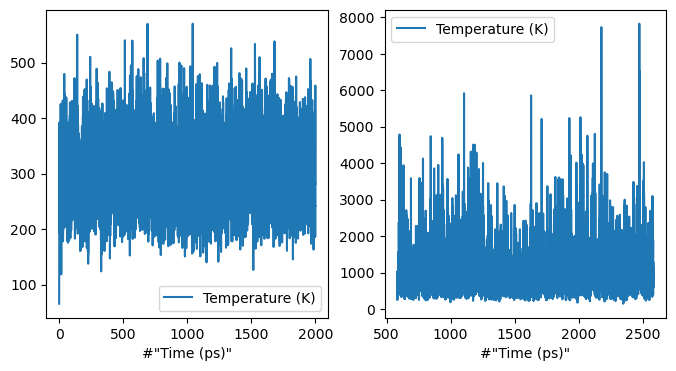

In [9]:
df1 = pandas.read_csv(f"{path}/scalars1_2ns.csv")
df2 = pandas.read_csv(f"{path}/scalars1_gad_2ns.csv")
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
df1.plot(kind="line", x='#"Time (ps)"', y="Temperature (K)", ax=ax[0])
df2.plot(kind="line", x='#"Time (ps)"', y="Temperature (K)", ax=ax[1])

In [27]:
traj1 = mdtraj.load("traj_openmm_gad_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
traj2 = mdtraj.load("traj_openmm_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")

nv.show_mdtraj(traj1)

NGLWidget(max_frame=9999)

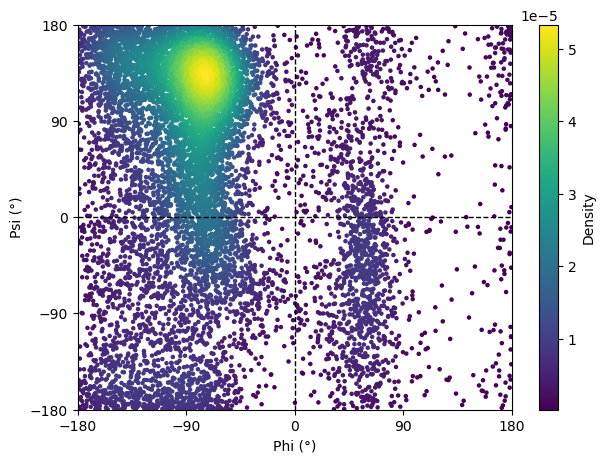

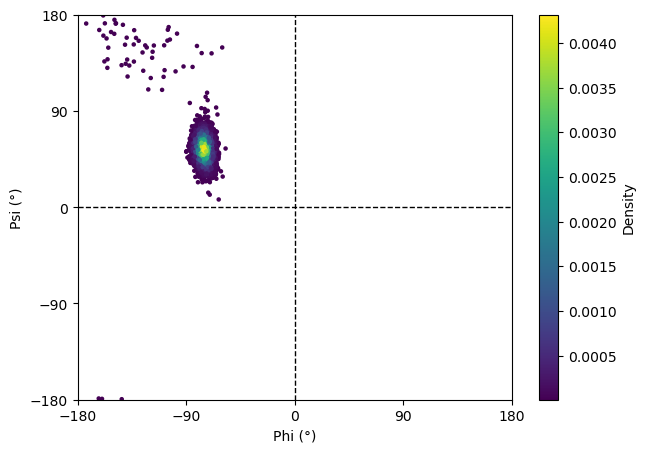

In [28]:
data1 = plot_ramachandran_contour(traj1, 'gad')
data2 = plot_ramachandran_contour(traj2, 'unbiased')